<a href="https://colab.research.google.com/github/VigneshNallamothu/HCD/blob/main/HCD_Executed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"siri1435","key":"1fd01855b89fd66a121495955aa885fb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c histopathologic-cancer-detection
!unzip histopathologic-cancer-detection.zip -d histopathologic-cancer-detection

Streaming output truncated to the last 5000 lines.
  inflating: histopathologic-cancer-detection/train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: histopathologic-cancer-detection/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: histopathologic-cancer-detection/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: histopathologic-cancer-detection/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: histopathologic-cancer-detection/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: histopathologic-cancer-detection/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: histopathologic-cancer-detection/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: histopathologic-cancer-detection/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: histopathologic-cancer-detection/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: histopathologic-cancer-detection/train/fa2e6d

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    VGG16,
    ResNet50,
    InceptionV3,
    DenseNet121,
    MobileNetV2,
)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
input_shape = (96, 96, 3)
batch_size = 32

In [ ]:
train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
train_path = 'histopathologic-cancer-detection/train'

Text(0, 0.5, 'Malignant')

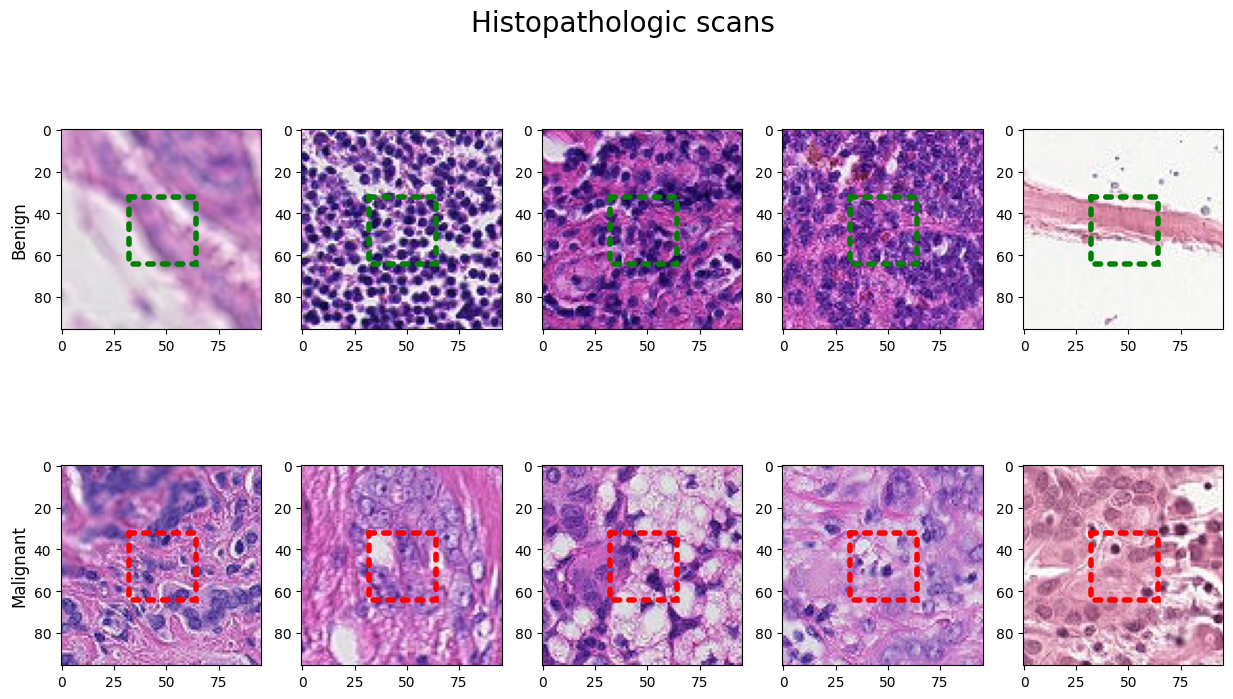

In [ ]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def readImg(path):
    img = cv2.imread(path)
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    return img

shuffled = shuffle(train_labels)

fig, ax = plt.subplots(2,5, figsize=(15,8))
fig.suptitle('Histopathologic scans',fontsize=20)

for i, idx in enumerate(shuffled[shuffled['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0, i].imshow(readImg(path + '.tif'))

    box = patches.Rectangle((32,32),32,32, linewidth  =4, edgecolor = 'green', facecolor = 'none', linestyle = ':', capstyle = 'round')
    ax[0, i].add_patch(box)
ax[0, 0].set_ylabel('Benign', size='large')

for i, idx in enumerate(shuffled[shuffled['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImg(path + '.tif'))

    box = patches.Rectangle((32,32),32,32, linewidth = 4, edgecolor = 'r', facecolor = 'none', linestyle = ':', capstyle = 'round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Malignant', size='large')

In [ ]:
train_labels['file_paths'] = train_labels['id'].apply(lambda x: os.path.join(train_path, x + '.tif'))

In [ ]:
def img_prep(train_path, label):
    img = tf.io.read_file(train_path)
    img = tf.image.decode_image(img, channels=3)

    img.set_shape((None, None, 3))

    img = tf.image.resize(img, (input_shape[0], input_shape[1]))

    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_labels['id'].map(lambda x: os.path.join('histopathologic-cancer-detection/train', f"{x}.tif")),
     train_labels['label'].astype(str))
)

train_dataset = (
    train_dataset
    .map(img_prep)
    .shuffle(buffer_size=1000)
    .batch(batch_size)
)

In [ ]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

In [ ]:
train_labels['label'] = train_labels['label'].astype(str)

In [ ]:
train_gen = gen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels,
    x_col = "file_paths",
    y_col = "label",
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "training",
    validate_filenames = False,
    seed = 10
)

validation_gen = gen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels,
    x_col = "file_paths",
    y_col = "label",
    target_size=(96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = False,
    seed = 10
)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.


In [ ]:
def model_training(model_name, num_classes):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Invalid model name")

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_names = ['VGG16', 'ResNet50', 'InceptionV3', 'DenseNet121', 'MobileNetV2']
results = {}

In [ ]:
for model_name in model_names:
    print(f"Training {model_name}...")
    model = model_training(model_name, num_classes=1)

    history = model.fit(
        train_gen,
        steps_per_epoch = len(train_gen),
        epochs = 5,
        validation_data = validation_gen,
        validation_steps = len(validation_gen),
        verbose = 1,
    )

    results[model_name] = history.history

Training VGG16...
58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/5
5501/5501 [==============================] - 171s 29ms/step - loss: 0.3466 - accuracy: 0.8473 - val_loss: 0.3111 - val_accuracy: 0.8653
Epoch 2/5
5501/5501 [==============================] - 157s 29ms/step - loss: 0.3099 - accuracy: 0.8665 - val_loss: 0.3096 - val_accuracy: 0.8678
Epoch 3/5
5501/5501 [==============================] - 158s 29ms/step - loss: 0.2953 - accuracy: 0.8737 - val_loss: 0.2921 - val_accuracy: 0.8752
Epoch 4/5
5501/5501 [==============================] - 158s 29ms/step - loss: 0.2842 - accuracy: 0.8800 - val_loss: 0.2846 - val_accuracy: 0.8797
Epoch 5/5
5501/5501 [==============================] - 158s 29ms/step - loss: 0.2748 - accuracy: 0.8839 - val_loss: 0.2800 - val_accuracy: 0.8841
Training ResNet50...
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/5
5501/5501 [==============================] - 167s 30ms/step - loss: 0.5583 - accuracy: 0.71

1376/1376 [==============================] - 33s 24ms/step


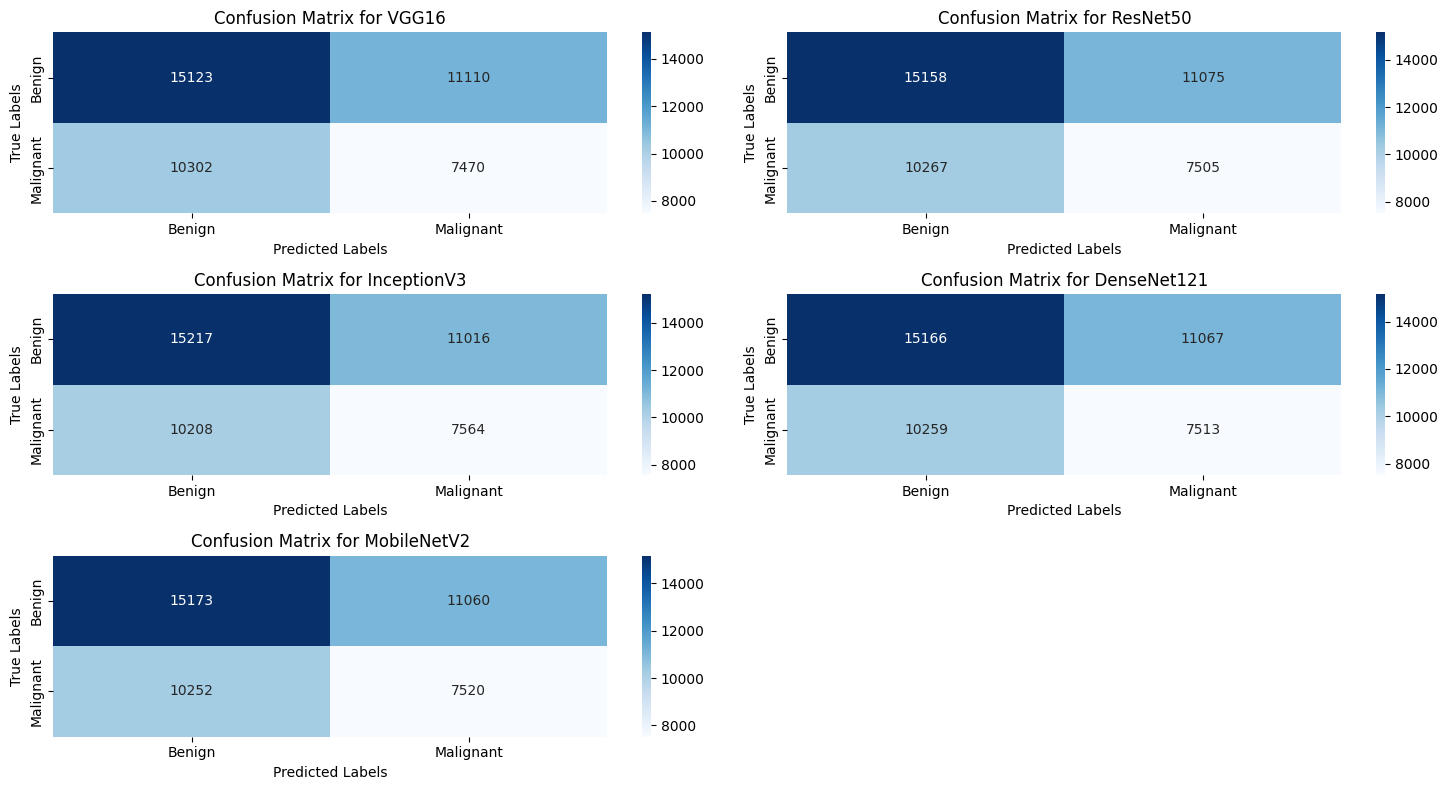

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

num_models = len(results)
num_cols = 2
num_rows = (num_models + 1) // num_cols

plt.figure(figsize=(15, 8))

for i, (model_name, history) in enumerate(results.items(), start=1):
    predictions = model.predict(validation_gen)
    y_true = validation_gen.classes
    y_pred = predictions > 0.5
    cm = confusion_matrix(y_true, y_pred)

    plt.subplot(num_rows, num_cols, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')

plt.tight_layout()
plt.show()

1376/1376 [==============================] - 33s 24ms/step


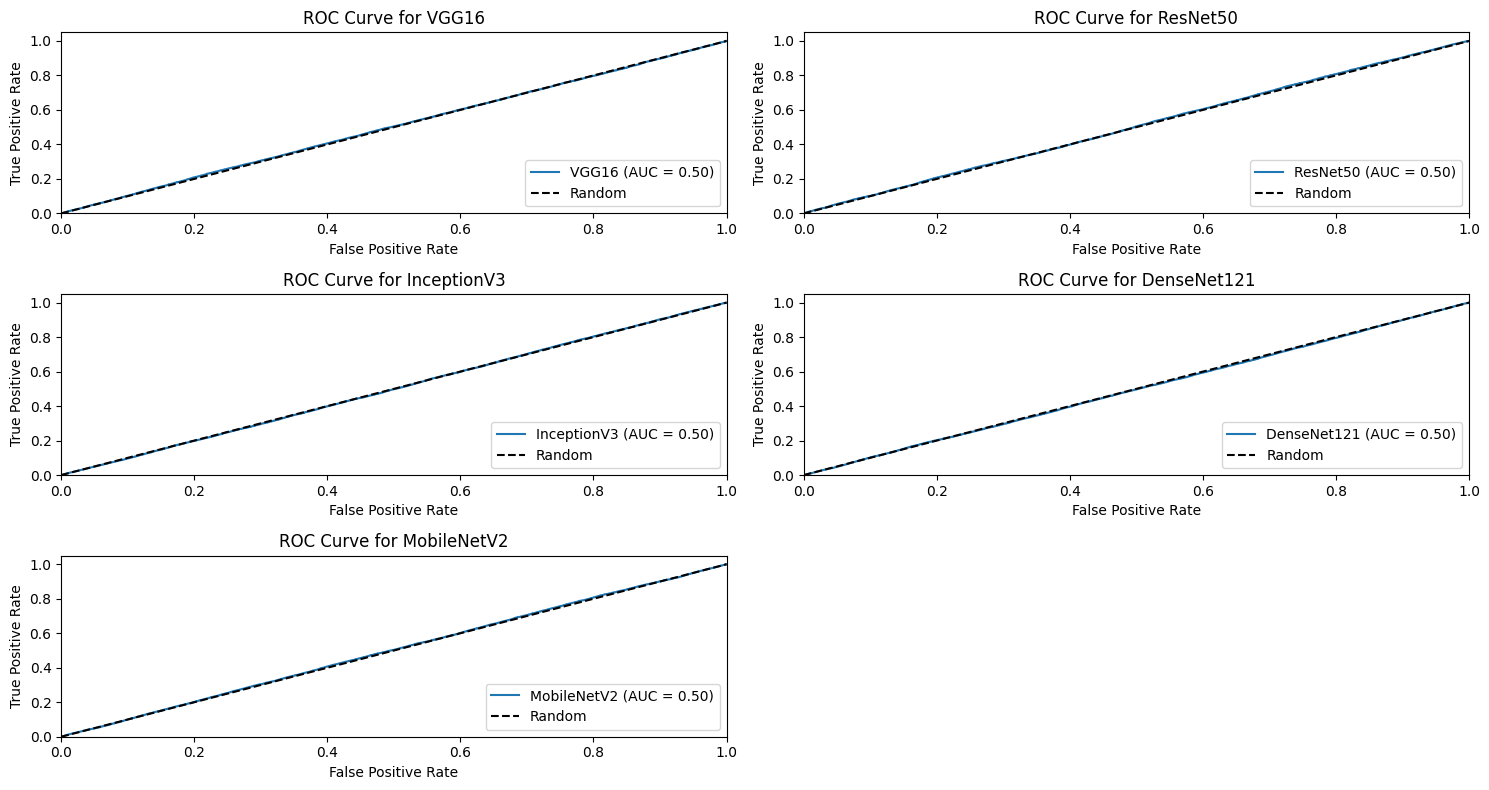

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

num_models = len(results)
num_cols = 2
num_rows = (num_models + 1) // num_cols

plt.figure(figsize=(15, 8))

for i, (model_name, history) in enumerate(results.items(), start=1):
    predictions = model.predict(validation_gen)
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    auc = roc_auc_score(y_true, predictions)

    plt.subplot(num_rows, num_cols, i)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

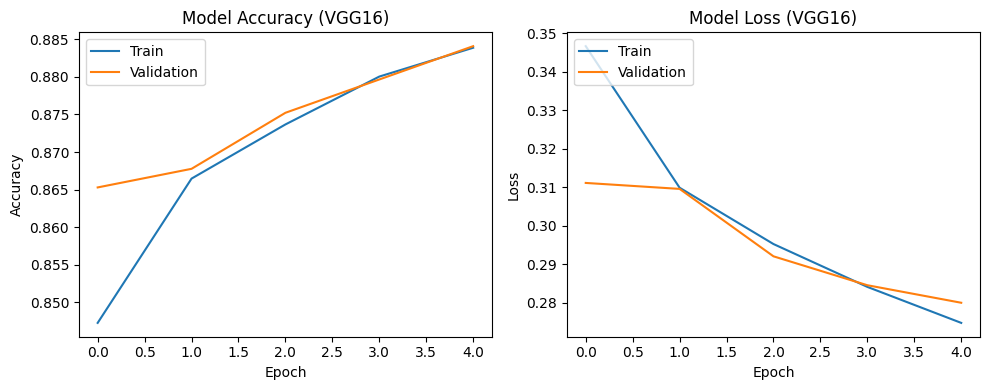

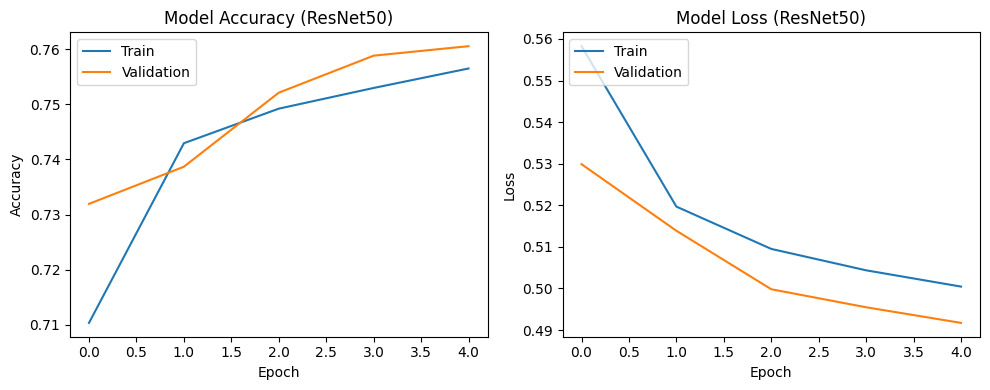

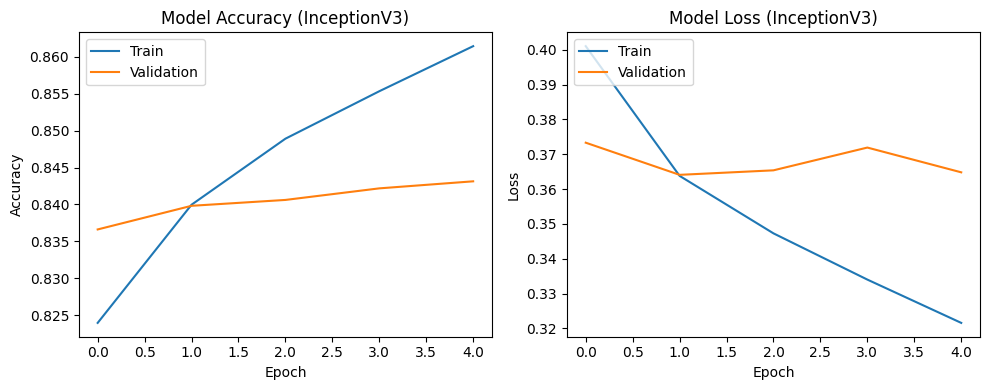

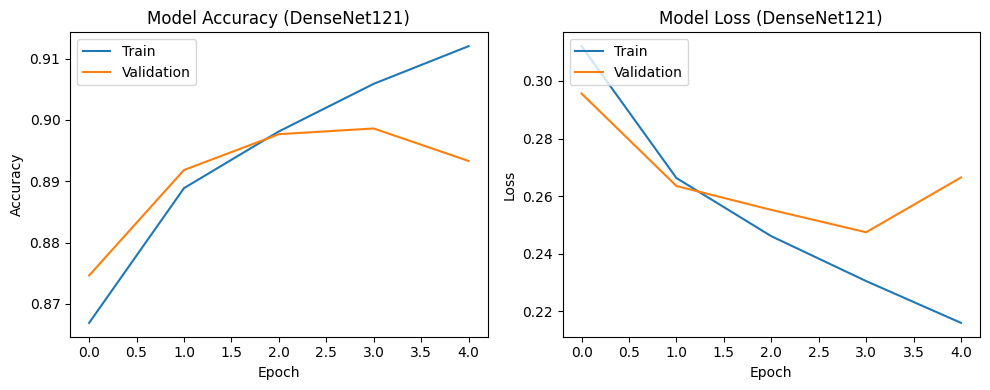

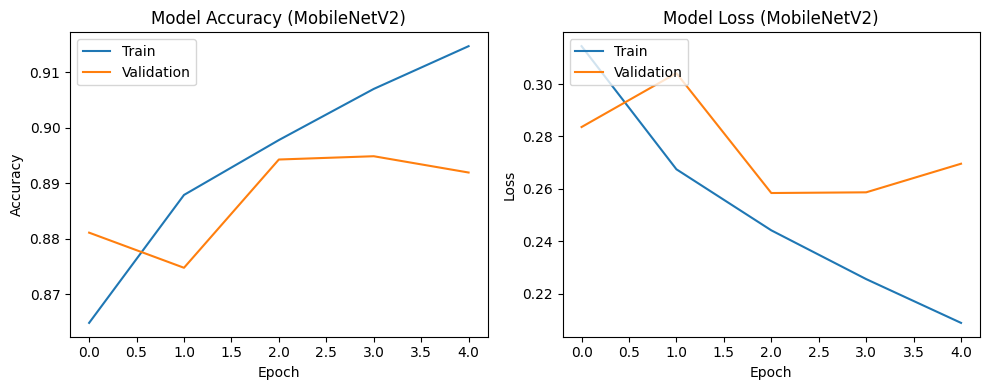

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history, model_name):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'Model Accuracy ({model_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'Model Loss ({model_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

for model_name, history in results.items():
    plot_metrics(history, model_name)

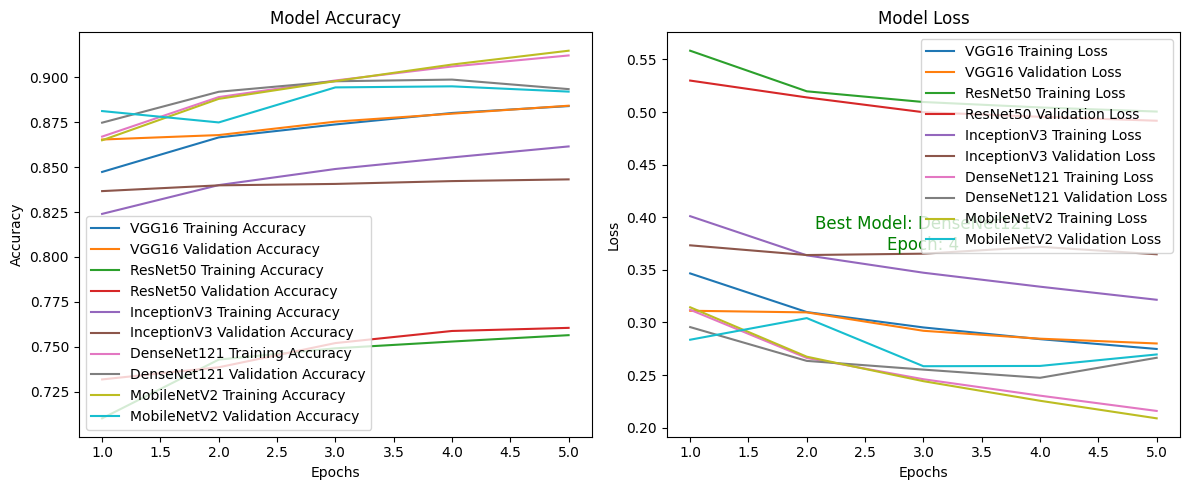

In [ ]:
import matplotlib.pyplot as plt

best_model_name = None
best_val_accuracy = 0
best_epoch = 0

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for model_name, history in results.items():
    epochs = range(1, len(history['accuracy']) + 1)
    axes[0].plot(epochs, history['accuracy'], label=f'{model_name} Training Accuracy')
    axes[0].plot(epochs, history['val_accuracy'], label=f'{model_name} Validation Accuracy')

    max_val_accuracy = max(history['val_accuracy'])
    if max_val_accuracy > best_val_accuracy:
        best_val_accuracy = max_val_accuracy
        best_model_name = model_name
        best_epoch = epochs[np.argmax(history['val_accuracy'])]

axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()

for model_name, history in results.items():
    epochs = range(1, len(history['loss']) + 1)
    axes[1].plot(epochs, history['loss'], label=f'{model_name} Training Loss')
    axes[1].plot(epochs, history['val_loss'], label=f'{model_name} Validation Loss')

axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()

plt.tight_layout()

plt.annotate(
    f'Best Model: {best_model_name}\nEpoch: {best_epoch}',
    xy=(0.5, 0.5),
    xycoords='axes fraction',
    fontsize=12,
    color='green',
    horizontalalignment='center',
    verticalalignment='center',
)

plt.show()

1376/1376 [==============================] - 33s 24ms/step


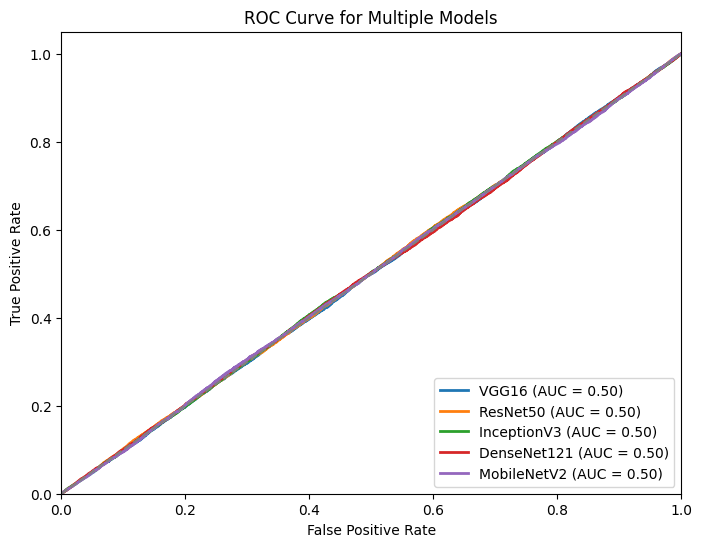

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for model_name, history in results.items():
    predictions = model.predict(validation_gen)
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        lw=2,
        label=f'{model_name} (AUC = {roc_auc:.2f})'
    )

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiple Models')
plt.legend(loc="lower right")

plt.show()

1376/1376 [==============================] - 33s 24ms/step


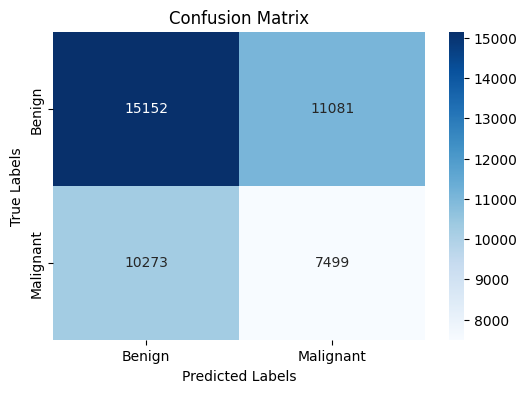

1376/1376 [==============================] - 33s 24ms/step


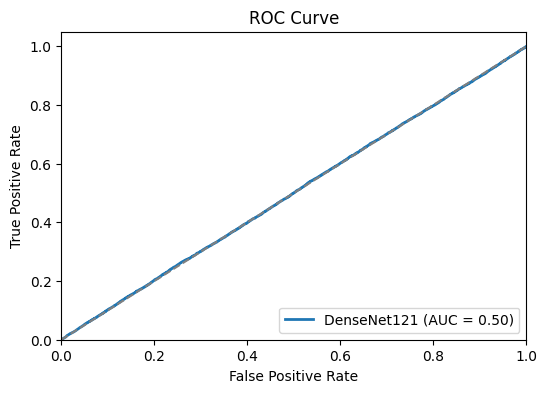

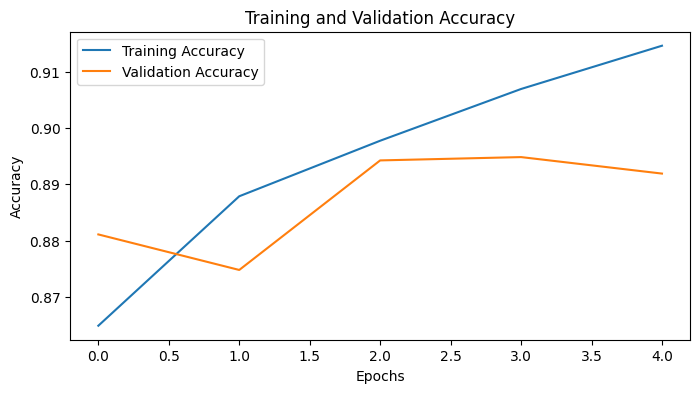

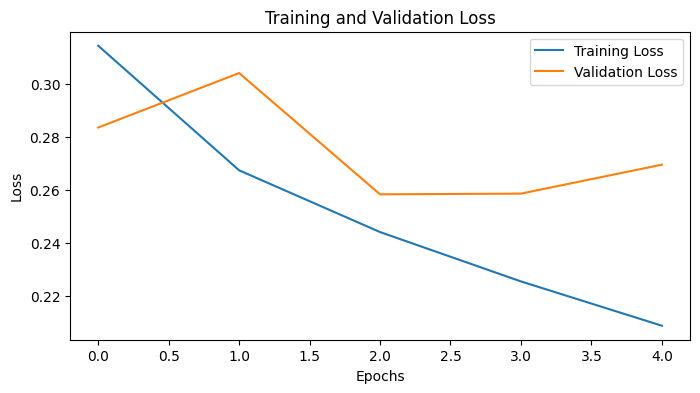

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

dense121_history = history
dense121_model = model

# 1. Confusion Matrix
def plot_confusion_matrix(model, X, y_true):
    y_pred = model.predict(X) > 0.5
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Benign', 'Malignant'],
        yticklabels=['Benign', 'Malignant']
    )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(dense121_model, validation_gen, validation_gen.classes)

# 2. ROC Curve
def plot_roc_curve(model, X, y_true):
    y_pred = model.predict(X)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, lw=2, label=f'DenseNet121 (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(dense121_model, validation_gen, validation_gen.classes)

# 3. Training and Validation Accuracy
plt.figure(figsize=(8, 4))
plt.plot(dense121_history['accuracy'], label='Training Accuracy')
plt.plot(dense121_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# 4. Training and Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(dense121_history['loss'], label='Training Loss')
plt.plot(dense121_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

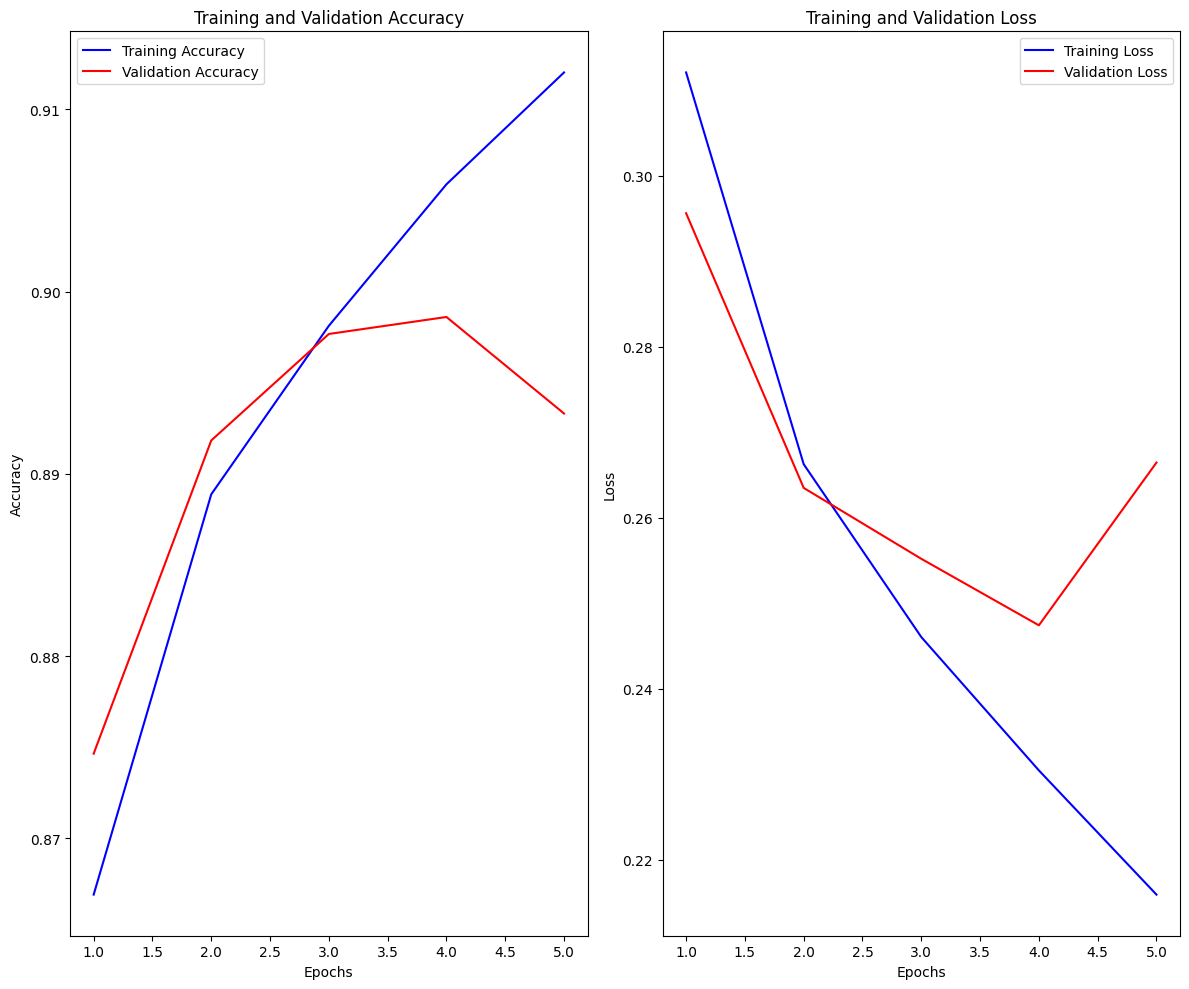

In [ ]:
import matplotlib.pyplot as plt

densenet121_history = results['DenseNet121']

accuracy = densenet121_history['accuracy']
val_accuracy = densenet121_history['val_accuracy']
loss = densenet121_history['loss']
val_loss = densenet121_history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()